In [20]:
import time
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import veritas

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Create a 2D synthetic dataset and take a look at it

In [21]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=2,
                           random_state=6)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25,
                                                random_state=6)

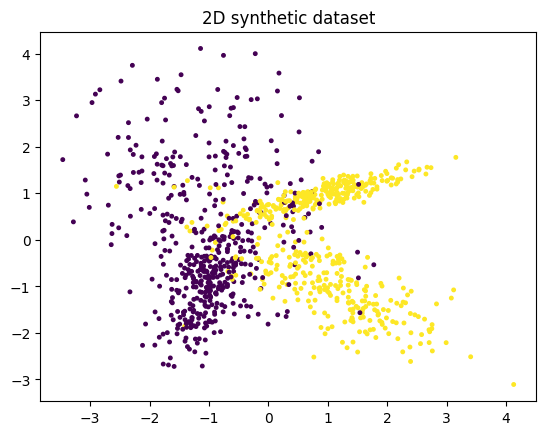

In [22]:
plt.figure()
plt.title("2D synthetic dataset")
plt.scatter(x[:, 0], x[:, 1], marker=".", c=y, s=25) #change color

## Train a sklearn RandomForest model

In [23]:
model = RandomForestClassifier(n_estimators=10).fit(xtrain, ytrain)
at = veritas.addtree_from_sklearn_ensemble(model)

SKLEARN: binary classifier


## ..., or train an XGBoost model

In [24]:
feat2id = lambda s: int(s[1:]) # xgboost names features f<n>, drop the `f`

model = xgb.XGBClassifier(n_estimators=10).fit(xtrain,ytrain)
at = veritas.addtree_from_xgb_model(model, feat2id) 

## Measure the predictive performance of the model

In [25]:
acc_train = accuracy_score(ytrain, model.predict(xtrain))
acc_test = accuracy_score(ytest, model.predict(xtest))
print(f"Train acc: {acc_train}, test acc: {acc_test} wrt true labels")

Train acc: 0.9453333333333334, test acc: 0.904 wrt true labels


## Use Veritas to evaluate adversarial accuracy and collect generated adversarial examples

Adversarial accuracy is the fraction of test examples that:

1. are correctly classified by the model
2. cannot be turned into a valid adversarial example (given perturbation margin eps)

In [26]:
eps = 0.1 #perturbation margin
ytest_pred = at.eval(xtest)>0

In [27]:
# will store results here 
adv_found, robust = [], []
advs = [] 

In [28]:
time_full_search = time.time()

for i in range(xtest.shape[0]):
    base_example = xtest[i, :]
    
    # only search on correctly classified examples
    # it is unclear what an adversarial example of a misclassified example is
    if ytest_pred[i] != ytest[i]:
        continue
        
    # veritas maximizes the model's output
    # to minimize the output, negate the leaves
    s = veritas.Search.max_output(at.negate_leaf_values() if ytest[i] else at) 
    
    # allow each attribute to vary of at most eps either side
    s.prune([veritas.Domain(x-eps, x+eps) for x in base_example]) 
    
    # make veritas stop the search when it is certain that the prediction cannot flip
    s.stop_when_upper_less_than = 0.0 
    
    # can set max time or num. steps per search
    # stop_reason allows to inspect why search ended - e.g., OPTIMAL: optimal solution reached (see all in veritas/src/cpp/search.hpp)
    max_num_seconds = 0.5
    num_steps = 500
    stop_reason = s.step_for(max_num_seconds, num_steps) 

    if s.num_solutions() > 0:
        # an adversarial example has been found
        adv_found.append(i)
        sol = s.get_solution(0) # if multiple ones were found, the best in in position 0

        advs.append({
                "index": i,
                "adv_example": veritas.get_closest_example(sol, base_example),
                "base_example": base_example
            })
    else:
        robust.append(i)
        

## Evaluate adversarial accuracy

In [29]:
num_test_examples = xtest.shape[0]
misclassified = ytest[ytest!=ytest_pred].shape[0]
print()
print(f"Wrongly classified examples: {misclassified}/{num_test_examples}")
print(f"Non-robust examples: {len(adv_found)}/{num_test_examples}")
print(f"Robust examples: {len(robust)}/{num_test_examples}")

print()
print(f">> Adversarial accuracy: {np.round(1-((misclassified+len(adv_found))/num_test_examples),3)}")
print(f">> Time for full search: {np.round(time.time()-time_full_search,3)} seconds")


Wrongly classified examples: 24/250
Non-robust examples: 19/250
Robust examples: 207/250

>> Adversarial accuracy: 0.828
>> Time for full search: 0.024 seconds


## Look at an example of an adversarial example

In [30]:
index, base_ex, adv_ex = advs[0]["index"], advs[0]["base_example"], advs[0]["adv_example"]
print()
print(f"Example for index {index}: \n\t - base example: {base_ex} \n\t - adversarial example: {adv_ex}\n")


Example for index 20: 
	 - base example: [0.45325164 0.87520918] 
	 - adversarial example: [0.44269338 0.80899227]

